In [27]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf

# tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

2.3.0


In [28]:
with open('language_data.csv','r',encoding='utf8') as k:
        data = k.read()
uncleaned_data = data.split('\n')
word_pairs = []
for sentence in uncleaned_data:
    word_pairs.append(sentence.split(','))
for word in word_pairs:
    word[0] = '<start> ' + word[0] + ' <end>'
    word[1] = '<start> ' + word[1] + ' <end>'
print(word_pairs)

IndexError: list index out of range

In [29]:
def create_dataset(path):
    with open(path,'r',encoding='utf8') as k:
        data = k.read()
    uncleaned_data = data.split('\n')[:150]
    word_pairs = []
    for sentence in uncleaned_data:
        a = []
        a.append(sentence.split('\t')[:-1][0])
        a.append(sentence.split('\t')[:-1][1])
        word_pairs.append(a)
    for word in word_pairs:
        word[0] = '<start> ' + word[0] + ' <end>'
        word[1] = '<start> ' + word[1] + ' <end>'
    return word_pairs

In [30]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
        self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [31]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path)

    # index language using the class defined above    
    inp_lang = LanguageIndex(en for en, kn in pairs)
    targ_lang = LanguageIndex(kn for en, kn in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, kn in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in kn.split(' ')] for en, kn in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [32]:
num_examples = 150
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset('C:/Users/Sumukh Kashi/Downloads/kan.txt', num_examples)

In [33]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.20)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(120, 120, 30, 30)

In [34]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 8
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
print(dataset)

<BatchDataset shapes: ((None, 14), (None, 11)), types: (tf.int32, tf.int32)>


In [35]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='he_uniform') #changed from glorot_uniform for better distribution

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        #Adding extra softmax layer
        #score = tf.nn.softmax(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        #attention_weights = tf.nn.relu(self.V(score))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * max_length, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [38]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [39]:
optimizer = tf.optimizers.Adam()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [40]:
EPOCHS = 25
loss_list = []

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder( inp,hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        total_loss += (loss / int(targ.shape[1]))
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
      
        optimizer.apply_gradients(zip(gradients, variables), tf.optimizers.SGD())

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         loss.numpy() / int(targ.shape[1])))
    loss_list.append(loss.numpy() / int(targ.shape[1]))
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss/len(input_tensor)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7917
Epoch 1 Loss 0.3009
Time taken for 1 epoch 11.960335493087769 sec

Epoch 2 Batch 0 Loss 2.6662
Epoch 2 Loss 0.2691
Time taken for 1 epoch 11.630171775817871 sec

Epoch 3 Batch 0 Loss 2.3650
Epoch 3 Loss 0.2535
Time taken for 1 epoch 11.553632497787476 sec

Epoch 4 Batch 0 Loss 2.5109
Epoch 4 Loss 0.2406
Time taken for 1 epoch 11.592616558074951 sec

Epoch 5 Batch 0 Loss 2.1054
Epoch 5 Loss 0.2261
Time taken for 1 epoch 11.617213010787964 sec

Epoch 6 Batch 0 Loss 2.3305
Epoch 6 Loss 0.2156
Time taken for 1 epoch 11.540555238723755 sec

Epoch 7 Batch 0 Loss 2.1154
Epoch 7 Loss 0.2067
Time taken for 1 epoch 11.595233917236328 sec

Epoch 8 Batch 0 Loss 2.1306
Epoch 8 Loss 0.1961
Time taken for 1 epoch 11.85274887084961 sec

Epoch 9 Batch 0 Loss 1.6539
Epoch 9 Loss 0.1787
Time taken for 1 epoch 11.659924030303955 sec

Epoch 10 Batch 0 Loss 1.6608
Epoch 10 Loss 0.1618
Time taken for 1 epoch 11.581582069396973 sec

Epoch 11 Batch 0 Loss 1.9243
Epoch 11 Loss 0.1443

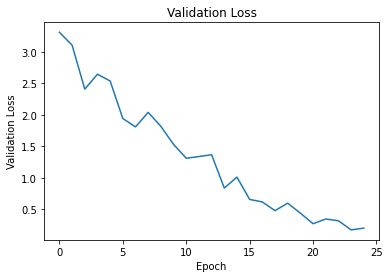

In [41]:
# importing the required module
import matplotlib.pyplot as plt

a = []
# x axis values
for i in range(EPOCHS):
    a.append(i)
x = a
# corresponding y axis values

y = loss_list

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('Epoch')
# naming the y axis
plt.ylabel('Validation Loss')

# giving a title to my graph
plt.title('Validation Loss')

# function to show the plot
plt.show()

In [21]:
import unicodedata
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
#     w = w.lower()
    
#     # creating a space between a word and the punctuation following it
#     # eg: "he is a boy." => "he is a boy ." 
#     # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
#     w = re.sub(r"([?.!,¿])", r" \1 ", w)
#     w = re.sub(r'[" "]+', " ", w)
    
#     # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
#     w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
#     w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [22]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.random.categorical(tf.exp(predictions), num_samples=1)[0][0].numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [23]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [24]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> How's your family? <end>
Predicted translation: ನಿಮ್ಮ ಮನೇಲಿ ಹೆಂಗಿದ್ದಾರೆ <end> 


<ipython-input-23-219babc300ac>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-23-219babc300ac>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3240 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3263 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3246 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3277 missing from current font.
  font.set_text(s, 0.0, flags=flags

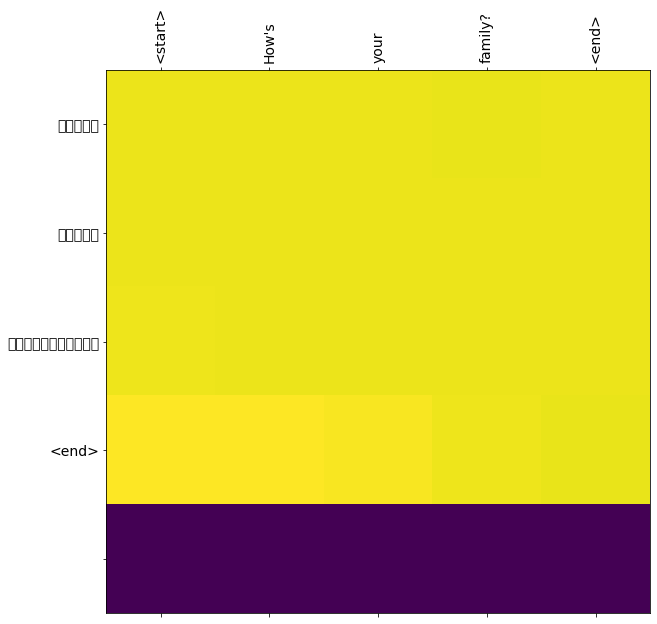

In [25]:
translate("How's your family?", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

In [24]:
pip install d2l

import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

SyntaxError: invalid syntax (<ipython-input-24-d56dd3727c3e>, line 1)

In [26]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['ಟಾಮ್','ಎಂದಾದರೂ','ನಿನ್ನನ್ನು','ನೋಯಿಸಿದ್ದಾನೆಯೇ?']]
hypothesis1 = ['ಟಾಮ್','ನಿನ್ನನ್ನು','ಯಾವಾಗಲಾದರೂ','ನೋಯಿಸಿದ್ದಾನಾ?']

score = sentence_bleu(reference, hypothesis1, weights=(1, 0, 0, 0))
print(score)

0.5


C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
